# Capstone Project - The Battle of the Neighborhoods

## "LloydMartin Redux - Illinois Edition"

## The Problem & Background

### LloydMartin was a restaurant in Seattle, Washington.  

It was "a small 34 seat restaurant whom offers a globally-inspired cuisine in which our menu changes daily based on seasonal ingredients. We reach out to the farms that produce the highest quality product based on seasonal availability. Some ingredients we love to serve are foie gras, Wagyu and Prime beef, ramps, truffles, risotto, housemade pastas, dayboat fish, and mushrooms!"

### LloydMartin was situated in Seattle's Queen Anne Neighborhood

LloydMartin restaurant was located at 1525 Queen Anne Ave N, Seattle, WA 98109 USA.  From Wikipedia: "Queen Anne Hill is an affluent neighborhood and geographic feature in Seattle, northwest of downtown."

### Chef Sam moved back to Illinois

Chef Sam left Seattle and moved back to Illinois in the last year, naturally, his friends and family are enquiring about his next restaurant.  

### Can Chef Sam replicate the success of LloydMartin by finding a similar location as LloydMartin?

This project will aim to seek a new restaurant location, based on available restaurant properties near Naperville, Illinois, USA.  The goal will be to find which rental properties would be similar to the LloydMartin's Queen Anne location.

## Description of the Data

This project will leverage Foursquare location data to understand Seattle's Queen Anne neighborhood, specifically the area nearest to the former location of LloydMartin restaurant (1525 Queen Anne Ave N, Seattle, WA 98109).

The project will also use Foursquare location data to explore and understand the neighborhoods around restaurant properties that are currently available near and around Naperville, Illinois, USA (near Chicago, IL).  48 rental properites are under consideration. The rental properties under consideration are listed in a CSV file, with the following columns "Address", "Price", and "Area_Sq_Ft".

Similar to our evaluation of neighborhoods in Manhattan and Toronto, we will cluster the available rental properties, as well as the LloydMartin location, based on the types of nearby venues from the Foursquare server.  We will look to identify a handful of rental properties to recommend to Chef Sam for a new Illinois restaurant that are in the same neighborhood cluster as LloydMartin's Queen Anne neighborhood.

**Note: in the process of inspecting the data, it appeared that the venue categories used by Foursquare were too specific.  A Python dictionary was created to map the Foursquare Venue Categories to broader venue categories (e.g. "Eastern European Restaurant" was mapped to "Restaurant").  This reduced unique venue categories from 206 unique categories down to 11.  This had the effect of improving the clustering, and making it more easily interpretable (as shown below).**

### Let's load the rental property data
Below code loads the list of rental properties that will be evaluated.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [2]:
url='C:/Users/alex/OneDrive/Documents/COursera/Capstone Project/RentalProp.csv'
rentals_df=pd.read_csv(url)

Here is what the rental data looks like.  It includes the address and basic listing information (price and area in square feet)

In [3]:
rentals_df.head()

,Address,Price,Area_Sq_Ft
0,"2801 E. Main Street, St Charles, IL",1150000,6999
1,"515 Madison Street, Oak Park, IL",845000,2548
2,"441 W Lake Street, Elmhurst, IL",1250000,4900
3,"4715 W 63rd St, Chicago, IL",1500000,4000
4,"10200 S Halsted St, Chicago, IL",1860000,2200


In [4]:
rentals_df.describe(include='all')

,Address,Price,Area_Sq_Ft
count,48,4.800000e+01,48.00000
unique,48,NaN,NaN
top,"2913 N Lincoln Ave, Chicago, IL",NaN,NaN
freq,1,NaN,NaN
mean,NaN,8.423298e+05,4518.37500
std,NaN,4.850113e+05,2457.64193
min,NaN,2.650000e+05,640.00000
25%,NaN,4.749750e+05,2693.75000
50%,NaN,6.844995e+05,4020.00000
75%,NaN,1.199250e+06,5597.25000


There are 48 unique properties, ranging in prince from \\$265,000 to \\$2,625,000.

In [5]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Address     48 non-null     object
 1   Price       48 non-null     int64 
 2   Area_Sq_Ft  48 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


Let's add a column to create Price per square foot for each of the listings... this is a normal attribute used to compare real estate properties

In [6]:
rentals_df['Price_per_Sqft']=rentals_df['Price']/rentals_df['Area_Sq_Ft']

In [7]:
rentals_df.describe()

,Price,Area_Sq_Ft,Price_per_Sqft
count,4.800000e+01,48.00000,48.000000
mean,8.423298e+05,4518.37500,222.079776
std,4.850113e+05,2457.64193,149.344319
min,2.650000e+05,640.00000,48.699187
25%,4.749750e+05,2693.75000,137.132208
50%,6.844995e+05,4020.00000,195.102235
75%,1.199250e+06,5597.25000,259.807173
max,2.625000e+06,12728.00000,845.454545


In [8]:
Locations_df=rentals_df[['Address']] #We will assign the Addresses to a new dataframe

In [9]:
Locations_df.head()

,Address
0,"2801 E. Main Street, St Charles, IL"
1,"515 Madison Street, Oak Park, IL"
2,"441 W Lake Street, Elmhurst, IL"
3,"4715 W 63rd St, Chicago, IL"
4,"10200 S Halsted St, Chicago, IL"


We will add the address of the Seatte, Washing restaurant "LloydMartin"

In [10]:
LloydMartinAddress = {'Address': ['1525 Queen Anne Ave N, Seattle, WA']}
LMA_df = pd.DataFrame.from_dict(LloydMartinAddress)

In [11]:
#Locations_df=Locations_df.append(LloydMartinAddress, ignore_index=True)
Locations_df = Locations_df.append(LMA_df, ignore_index=True)

In [12]:
Locations_df.tail() # let's see what we appended... looks good

,Address
44,"1114 Madison St, Oak Park, IL"
45,"621 E Saint Charles Rd, Villa Park, IL"
46,"144 E North Ave, Northlake, IL"
47,"672 N Mill Rd, Addison, IL"
48,"1525 Queen Anne Ave N, Seattle, WA"


## Importing more libraries & Using Geocode to get Lat/Longitude Coordinates for our properties

In [13]:
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


In [14]:
address = '1525 Queen Anne Ave N, Seattle, WA'

geolocator = Nominatim(user_agent="Naperville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of LloydMiller was {}, {}.'.format(latitude, longitude))

The geograpical coordinate of LloydMiller was 47.6331401, -122.3572603.


In [15]:
address = '9769 W Grand Ave, Franklin Park, IL'

geolocator = Nominatim(user_agent="Naperville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of LloydMiller was {}, {}.'.format(latitude, longitude))

The geograpical coordinate of LloydMiller was 41.929738166428514, -87.86955704307276.


In [16]:
# Getting the Lattitude and Longitude for each rental property
Latitude_list=[]
Longitude_list=[]


for rental_address in Locations_df['Address']: 
    geolocator = Nominatim(user_agent="address_explorer")
    location = geolocator.geocode(rental_address)
    
    if location is None:#Some addresses were returning None, so for those few (5 out of 48 properties) we will just reference the city coordinates
        street_number,city,state = rental_address.split(",")
        rental_address=city+", "+ "Illinois, USA"
        location = geolocator.geocode(rental_address)
        Latitude_list.append(latitude)
        Longitude_list.append(longitude)
    else:
        latitude = location.latitude
        longitude = location.longitude
        Latitude_list.append(latitude)
        Longitude_list.append(longitude)

In [17]:
Locations_df['Latitude']=Latitude_list
Locations_df['Longitude']=Longitude_list
Locations_df.head(49)

,Address,Latitude,Longitude
0,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703
1,"515 Madison Street, Oak Park, IL",41.879764,-87.789129
2,"441 W Lake Street, Elmhurst, IL",41.905975,-87.917068
3,"4715 W 63rd St, Chicago, IL",41.778222,-87.740447
4,"10200 S Halsted St, Chicago, IL",41.708391,-87.643175
5,"2410 Ogden Ave, Downers Grove, IL",41.805908,-88.043546
6,"40W089 IL-64, Saint Charles, IL",41.805908,-88.043546
7,"6312 S Harlem Ave, Summit, IL",41.775356,-87.800936
8,"1422-1424 W Chicago Ave, Chicago, IL",41.896376,-87.663448
9,"600 E Veterans Parkway, Yorkville, IL",41.676452,-88.396870


# Methodology:

In this section we weill create a map of the restaurant locations we will evaluate.  We will then query Foursquare to retrieve nearby venues.  We will further simplify the Foursquare venue data by mapping the venue categories to more generalized categories.  Additionally, we will apply one-hot coding to then create a new dataframe by taking a mean-weighted averages of the venue categories.  We will focus on the top 5 most common nearby venue categories for each property. This new dataframe will allow us to apply an unsupervised classification algorithm, namely kmeans clustering.

Once we have generated out clusters, we will review the contents of each cluster to further understand what the properties have in common and how the clusters differ.  We will also inspect the clusters using scatterplots to visualize some of the key variables that influenced the kmeans clustering algorithm.  Last, we will also inspect to see if there was any correlation to variables not used in the clustering process (specifically, the price and square footage of each property).


## Creating a map of the Restaurant Property Locations

In [18]:
address = 'Naperville, IL'

geolocator = Nominatim(user_agent="Naperville_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Naperville using latitude and longitude values
map_locations = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, addresses in zip(Locations_df['Latitude'], Locations_df['Longitude'], Locations_df['Address']):
    label = '{}'.format(addresses)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_locations)  
    
map_locations

# Interfacing with the Foursquare Venues API

In [19]:
CLIENT_ID = 'LQKHRVKGTNXXJNXGVLLG4Z5WX4DG1MQAH4UBOPBF250ZV2F1' # your Foursquare ID
CLIENT_SECRET = 'YBYXRY115ANCNDMUCG40VWJE3W0VQ0RHNPZ0FVCQBHTK1DRV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [20]:
radius = 150 # radius of 250 grouped 19 properties
LIMIT=100

In [21]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
Addresses_venues = getNearbyVenues(names=Locations_df['Address'],
                                   latitudes=Locations_df['Latitude'],
                                   longitudes=Locations_df['Longitude']
                                  ) 

2801 E. Main Street, St Charles, IL
515 Madison Street, Oak Park, IL
441 W Lake Street, Elmhurst, IL
4715 W 63rd St, Chicago, IL
10200 S Halsted St, Chicago, IL
2410 Ogden Ave, Downers Grove, IL
40W089 IL-64, Saint Charles, IL
6312 S Harlem Ave, Summit, IL
1422-1424 W Chicago Ave, Chicago, IL
600 E Veterans Parkway, Yorkville, IL
8819 Ogden Ave, Brookfield, IL
155 E Veterans Parkway, Yorkville, IL
3108 N Central Ave, Chicago, IL
6900 W 111th Street, Worth, IL
1420 Ogden Ave, Downers Grove, IL
8347 W Grand Ave, River Grove, IL
3155 N Halsted Street, Chicago, IL
8420 S 88th Ave, Justice, IL
30 S La Grange Rd, La Grange, IL
6 W Roosevelt Rd, Lombard, IL
2723 N Halsted St, Chicago, IL
10036 S Western Ave, Chicago, IL
6831 W North Ave, Oak Park, IL
460 S 1st St, Saint Charles, IL
7141 79th Street, Burbank, IL
227 W Wilson St, Batavia, IL
1152 W Taylor St, Chicago, IL
211 N River St, Montgomery, IL
720 E North Ave, Carol Stream, IL
1948 W Chicago Ave, Chicago, IL
3011 Ogden Ave, Lisle, IL
29

In [24]:
Addresses_venues.groupby('Address').count()
#this cell shows us how many venues were extracted in each neighborhood

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Address,,,,,,
"10036 S Western Ave, Chicago, IL",16,16,16,16,16,16
"10200 S Halsted St, Chicago, IL",8,8,8,8,8,8
"10350 S Western Ave, Chicago, IL",21,21,21,21,21,21
"107 N Oak Park Ave, Oak Park, IL",41,41,41,41,41,41
"1114 Madison St, Oak Park, IL",15,15,15,15,15,15
"1152 W Taylor St, Chicago, IL",43,43,43,43,43,43
"1420 Ogden Ave, Downers Grove, IL",17,17,17,17,17,17
"1422-1424 W Chicago Ave, Chicago, IL",54,54,54,54,54,54
"144 E North Ave, Northlake, IL",3,3,3,3,3,3


In [25]:
print('Before simplifying the Foursquare Venue Categories, there are {} uniques categories.'.format(len(Addresses_venues['Venue Category'].unique())))

Before simplifying the Foursquare Venue Categories, there are 207 uniques categories.


Let's simplify the Venue Categories using by uploading a CSV that we will use as a dictionary to map

In [26]:
import csv
 
with open('C:/Users/alex/OneDrive/Documents/COursera/Capstone Project/venue_category.csv', encoding='utf-8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    New_venue_dict =  dict([row for row in csv_reader])
 
print(New_venue_dict)

{'Venue Category': 'New Venue Category', 'Bakery': 'Food Store', 'Sandwich Place': 'Restaurant', 'Thrift / Vintage Store': 'Shop', 'Furniture / Home Store': 'Shop', 'Vietnamese Restaurant': 'Restaurant', 'Liquor Store': 'Food Store', 'Chinese Restaurant': 'Restaurant', 'Italian Restaurant': 'Restaurant', 'Fast Food Restaurant': 'Restaurant', 'Discount Store': 'Shop', 'Mexican Restaurant': 'Restaurant', 'Steakhouse': 'Restaurant', 'Pizza Place': 'Restaurant', 'Miscellaneous Shop': 'Shop', 'Rental Car Location': 'Transportation', 'Donut Shop': 'Food Store', 'Hotel': 'Transportation', 'Breakfast Spot': 'Restaurant', 'American Restaurant': 'Restaurant', 'Japanese Restaurant': 'Restaurant', 'Pharmacy': 'Shop', 'Arts & Entertainment': 'Entertainment', 'Moving Target': 'Shop', 'Southern / Soul Food Restaurant': 'Restaurant', 'Gym / Fitness Center': 'Entertainment', 'Toy / Game Store': 'Shop', 'Bank': 'Bank', 'Fried Chicken Joint': 'Restaurant', 'Supermarket': 'Food Store', 'Convenience Store'

In [27]:
Addresses_venues['Venue Category'] = Addresses_venues['Venue Category'].map(New_venue_dict)

In [28]:
Addresses_venues.head() #Let's see what the new dataframe looks like

,Address,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703,Panera Bread,41.920816,-88.277387,Food Store
1,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703,Jersey Mike's Subs,41.921497,-88.283210,Restaurant
2,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703,Goodwill,41.922986,-88.279067,Shop
3,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703,World Market,41.919063,-88.273783,Shop
4,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703,Pho 95,41.923381,-88.278682,Restaurant


In [29]:
print('There are {} uniques categories.  This is a much simpler list of categories that will improve our interpretability.'.format(len(Addresses_venues['Venue Category'].unique())))

There are 11 uniques categories.  This is a much simpler list of categories that will improve our interpretability.


### Below code we will convert the venues dataframe using 1-hot encoding to make it suitable for k-Means clustering.

In [30]:
# one hot encoding
properties_onehot = pd.get_dummies(Addresses_venues[['Venue Category']], prefix="", prefix_sep="")

# add restaurant property column back to dataframe
properties_onehot['Address'] = Addresses_venues['Address'] 

# move restaurant property address column to the first column
fixed_columns = [properties_onehot.columns[-1]] + list(properties_onehot.columns[:-1])
properties_onehot = properties_onehot[fixed_columns]

properties_onehot.head()

,Address,Bank,Entertainment,Food Store,Gastropub,Living Space,Office,Other,Restaurant,Shop,Transportation
0,"2801 E. Main Street, St Charles, IL",0,0,1,0,0,0,0,0,0,0
1,"2801 E. Main Street, St Charles, IL",0,0,0,0,0,0,0,1,0,0
2,"2801 E. Main Street, St Charles, IL",0,0,0,0,0,0,0,0,1,0
3,"2801 E. Main Street, St Charles, IL",0,0,0,0,0,0,0,0,1,0
4,"2801 E. Main Street, St Charles, IL",0,0,0,0,0,0,0,1,0,0


In [31]:
properties_onehot.shape

(1180, 11)

In [32]:
properties_grouped = properties_onehot.groupby('Address').mean().reset_index()
properties_grouped

,Address,Bank,Entertainment,Food Store,Gastropub,Living Space,Office,Other,Restaurant,Shop,Transportation
0,"10036 S Western Ave, Chicago, IL",0.000000,0.312500,0.062500,0.000000,0.00000,0.00000,0.000000,0.500000,0.062500,0.062500
1,"10200 S Halsted St, Chicago, IL",0.000000,0.000000,0.125000,0.000000,0.00000,0.00000,0.000000,0.625000,0.250000,0.000000
2,"10350 S Western Ave, Chicago, IL",0.000000,0.285714,0.047619,0.000000,0.00000,0.00000,0.000000,0.380952,0.285714,0.000000
3,"107 N Oak Park Ave, Oak Park, IL",0.024390,0.219512,0.048780,0.000000,0.02439,0.00000,0.024390,0.365854,0.268293,0.024390
4,"1114 Madison St, Oak Park, IL",0.066667,0.266667,0.066667,0.000000,0.00000,0.00000,0.000000,0.400000,0.200000,0.000000
5,"1152 W Taylor St, Chicago, IL",0.023256,0.186047,0.046512,0.000000,0.00000,0.00000,0.000000,0.534884,0.209302,0.000000
6,"1420 Ogden Ave, Downers Grove, IL",0.000000,0.176471,0.058824,0.000000,0.00000,0.00000,0.000000,0.352941,0.352941,0.058824
7,"1422-1424 W Chicago Ave, Chicago, IL",0.000000,0.407407,0.000000,0.000000,0.00000,0.00000,0.000000,0.425926,0.166667,0.000000
8,"144 E North Ave, Northlake, IL",0.000000,0.000000,0.333333,0.000000,0.00000,0.00000,0.333333,0.000000,0.000000,0.333333
9,"1525 Queen Anne Ave N, Seattle, WA",0.057143,0.428571,0.142857,0.000000,0.00000,0.00000,0.000000,0.200000,0.142857,0.028571


In [33]:
properties_grouped.shape

(49, 11)

## Let's look at the 5 most common venues in the surrounding area

In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Address']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
properties_venues_sorted = pd.DataFrame(columns=columns)
properties_venues_sorted['Address'] = properties_grouped['Address']

for ind in np.arange(properties_grouped.shape[0]):
    properties_venues_sorted.iloc[ind, 1:] = return_most_common_venues(properties_grouped.iloc[ind, :], num_top_venues)

properties_venues_sorted.head()

,Address,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"10036 S Western Ave, Chicago, IL",Restaurant,Entertainment,Transportation,Shop,Food Store
1,"10200 S Halsted St, Chicago, IL",Restaurant,Shop,Food Store,Transportation,Other
2,"10350 S Western Ave, Chicago, IL",Restaurant,Shop,Entertainment,Food Store,Transportation
3,"107 N Oak Park Ave, Oak Park, IL",Restaurant,Shop,Entertainment,Food Store,Transportation
4,"1114 Madison St, Oak Park, IL",Restaurant,Entertainment,Shop,Food Store,Bank


## 1, 2, 3 time to Cluster

In [36]:
# set number of clusters
kclusters = 5

properties_grouped_clustering = properties_grouped.drop('Address', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=3).fit(properties_grouped_clustering)

In [37]:
# add clustering labels
properties_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

properties_merged = Locations_df

# merge properties_grouped with venue data to add latitude/longitude for each neighborhood
properties_merged = properties_merged.join(properties_venues_sorted.set_index('Address'), on='Address')

properties_merged.head() # check the last columns!

,Address,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703,4,Restaurant,Shop,Transportation,Food Store,Entertainment
1,"515 Madison Street, Oak Park, IL",41.879764,-87.789129,4,Restaurant,Transportation,Shop,Food Store,Entertainment
2,"441 W Lake Street, Elmhurst, IL",41.905975,-87.917068,1,Shop,Restaurant,Food Store,Transportation,Other
3,"4715 W 63rd St, Chicago, IL",41.778222,-87.740447,0,Restaurant,Shop,Entertainment,Transportation,Other
4,"10200 S Halsted St, Chicago, IL",41.708391,-87.643175,0,Restaurant,Shop,Food Store,Transportation,Other


In [38]:
address2 = 'Bolingbrook, IL'

geolocator2 = Nominatim(user_agent="Naperville_explorer")
location2 = geolocator2.geocode(address2)
latitude2 = location2.latitude
longitude2 = location2.longitude

# create map
map_clusters2 = folium.Map(location=[latitude2, longitude2], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(properties_merged['Latitude'], properties_merged['Longitude'], properties_merged['Address'],properties_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-0],
        fill=True,
        fill_color=rainbow[cluster-0],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

The orange markers correspond to Cluster 3, which is the cluster that includes our restaurant of interest (LloydMiller Restaurant).  Right away, I found it interesting that the rental properties up and down the Fox River were in the LloydMiller cluster, as well as a few select properties in Chicago.

We will further explore these results below

# Results:  What are the clusters?
### Cluster 0

This cluster appears to have "Restaurant" as the most common venue, but interestingly, LloydMiller did not fall into this cluster.

In [39]:
properties_merged.loc[properties_merged['Cluster Labels'] == 0, properties_merged.columns[[0,1,2] + list(range(4, properties_merged.shape[1]))]]

,Address,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,"4715 W 63rd St, Chicago, IL",41.778222,-87.740447,Restaurant,Shop,Entertainment,Transportation,Other
4,"10200 S Halsted St, Chicago, IL",41.708391,-87.643175,Restaurant,Shop,Food Store,Transportation,Other
10,"8819 Ogden Ave, Brookfield, IL",41.816379,-87.841179,Restaurant,Food Store,Entertainment,Transportation,Shop
18,"30 S La Grange Rd, La Grange, IL",41.814616,-87.869891,Restaurant,Entertainment,Shop,Food Store,Gastropub
19,"6 W Roosevelt Rd, Lombard, IL",41.860545,-87.990435,Restaurant,Shop,Transportation,Food Store,Other
22,"6831 W North Ave, Oak Park, IL",41.908909,-87.797416,Restaurant,Shop,Entertainment,Food Store,Transportation
24,"7141 79th Street, Burbank, IL",41.748429,-87.781433,Restaurant,Food Store,Entertainment,Transportation,Shop
26,"1152 W Taylor St, Chicago, IL",41.869629,-87.656305,Restaurant,Shop,Entertainment,Food Store,Bank
41,"9769 W Grand Ave, Franklin Park, IL",41.929738,-87.869557,Restaurant,Shop,Entertainment,Transportation,Food Store
47,"672 N Mill Rd, Addison, IL",41.939613,-88.003237,Restaurant,Entertainment,Shop,Food Store,Bank


### Cluster 1

This cluster is notable for what types of venues are lacking...  Notice that none of the top 5 most common venues for these properties include "Entertainment".

In [40]:
properties_merged.loc[properties_merged['Cluster Labels'] == 1, properties_merged.columns[[0,1,2] + list(range(4, properties_merged.shape[1]))]]

,Address,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
2,"441 W Lake Street, Elmhurst, IL",41.905975,-87.917068,Shop,Restaurant,Food Store,Transportation,Other
7,"6312 S Harlem Ave, Summit, IL",41.775356,-87.800936,Restaurant,Food Store,Transportation,Shop,Other
32,"3206 W Washington Blvd, Chicago, IL",41.882873,-87.706439,Shop,Restaurant,Food Store,Transportation,Other
46,"144 E North Ave, Northlake, IL",41.910254,-87.919077,Transportation,Other,Food Store,Shop,Restaurant


### Cluster 2

This small cluster also lacks any connection to "Entertainment" venues, and has "Restaurant", "Transportation", and "Shop"s as top venues.

In [41]:
properties_merged.loc[properties_merged['Cluster Labels'] == 2, properties_merged.columns[[0,1,2] + list(range(4, properties_merged.shape[1]))]]

,Address,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
17,"8420 S 88th Ave, Justice, IL",41.737605,-87.838356,Restaurant,Transportation,Shop,Other,Office
33,"8350 S 88th Ave, Justice, IL",41.738789,-87.838392,Restaurant,Transportation,Shop,Other,Office


### Cluster 3 - Cluster with LloydMiller Restaurant!

A total of 16 available properties' neighborhoods were clustered with the LloydMiller restaurant's Queen Anne location.  We will explore this cluster in more detail in the next section (after we look at Cluster 4 properties) to see what makes this properties 'special'.

In [42]:
properties_merged.loc[properties_merged['Cluster Labels'] == 3, properties_merged.columns[[0,1,2] + list(range(4, properties_merged.shape[1]))]]

,Address,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
8,"1422-1424 W Chicago Ave, Chicago, IL",41.896376,-87.663448,Restaurant,Entertainment,Shop,Transportation,Other
9,"600 E Veterans Parkway, Yorkville, IL",41.676452,-88.396870,Restaurant,Entertainment,Transportation,Shop,Other
11,"155 E Veterans Parkway, Yorkville, IL",41.676452,-88.396870,Restaurant,Entertainment,Transportation,Shop,Other
15,"8347 W Grand Ave, River Grove, IL",41.928426,-87.834947,Entertainment,Shop,Restaurant,Transportation,Other
16,"3155 N Halsted Street, Chicago, IL",41.939462,-87.648950,Restaurant,Entertainment,Shop,Food Store,Transportation
20,"2723 N Halsted St, Chicago, IL",41.932290,-87.648669,Restaurant,Entertainment,Shop,Food Store,Office
21,"10036 S Western Ave, Chicago, IL",41.710766,-87.682041,Restaurant,Entertainment,Transportation,Shop,Food Store
23,"460 S 1st St, Saint Charles, IL",41.909459,-88.313139,Entertainment,Restaurant,Food Store,Transportation,Shop
25,"227 W Wilson St, Batavia, IL",41.850034,-88.310957,Restaurant,Entertainment,Shop,Food Store,Bank
27,"211 N River St, Montgomery, IL",41.729291,-88.341051,Restaurant,Food Store,Entertainment,Shop,Transportation


### Cluster 4

This 4th and largest cluster has "Restaurant" and "Shops" predominantly as the most common Venues.

In [43]:
properties_merged.loc[properties_merged['Cluster Labels'] == 4, properties_merged.columns[[0,1,2] + list(range(4, properties_merged.shape[1]))]]

,Address,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"2801 E. Main Street, St Charles, IL",41.921177,-88.278703,Restaurant,Shop,Transportation,Food Store,Entertainment
1,"515 Madison Street, Oak Park, IL",41.879764,-87.789129,Restaurant,Transportation,Shop,Food Store,Entertainment
5,"2410 Ogden Ave, Downers Grove, IL",41.805908,-88.043546,Restaurant,Shop,Transportation,Entertainment,Other
6,"40W089 IL-64, Saint Charles, IL",41.805908,-88.043546,Restaurant,Shop,Transportation,Entertainment,Other
12,"3108 N Central Ave, Chicago, IL",41.936984,-87.766869,Restaurant,Shop,Entertainment,Bank,Food Store
13,"6900 W 111th Street, Worth, IL",41.690221,-87.791149,Restaurant,Shop,Food Store,Entertainment,Bank
14,"1420 Ogden Ave, Downers Grove, IL",41.806905,-88.037795,Shop,Restaurant,Entertainment,Transportation,Food Store
29,"1948 W Chicago Ave, Chicago, IL",41.896109,-87.676522,Restaurant,Shop,Entertainment,Food Store,Transportation
30,"3011 Ogden Ave, Lisle, IL",41.896109,-87.676522,Restaurant,Shop,Entertainment,Food Store,Transportation
34,"107 N Oak Park Ave, Oak Park, IL",41.887525,-87.794593,Restaurant,Shop,Entertainment,Food Store,Transportation


### Let's plot some of the venue data to better understand the clusters

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
# add clustering labels
properties_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

properties_with_listings_merged = rentals_df

# merge properties_grouped with venue data to add latitude/longitude for each neighborhood
properties_with_listings_merged = properties_with_listings_merged.join(properties_grouped.set_index('Address'), on='Address', how='right')

properties_with_listings_merged=properties_with_listings_merged.set_index('Address')
properties_with_listings_merged.head(3)

,Price,Area_Sq_Ft,Price_per_Sqft,Cluster Labels,Bank,Entertainment,Food Store,Gastropub,Living Space,Office,Other,Restaurant,Shop,Transportation
Address,,,,,,,,,,,,,,
"2801 E. Main Street, St Charles, IL",1150000.0,6999.0,164.309187,4,0.0000,0.034483,0.137931,0.0,0.0,0.0,0.000,0.482759,0.206897,0.137931
"515 Madison Street, Oak Park, IL",845000.0,2548.0,331.632653,4,0.0625,0.062500,0.062500,0.0,0.0,0.0,0.000,0.312500,0.250000,0.250000
"441 W Lake Street, Elmhurst, IL",1250000.0,4900.0,255.102041,1,0.0000,0.000000,0.250000,0.0,0.0,0.0,0.125,0.250000,0.250000,0.125000


# Discussion: 

## In the following code, we will use a series of scatter plots to visualize how k-Means clustered the properties by inspecting 2 variables at a time.  We will discuss our observations based on these scatter plots and recommendations.

### I am plotting **<font color='orange'>Cluster 3 in ORANGE</font>.**

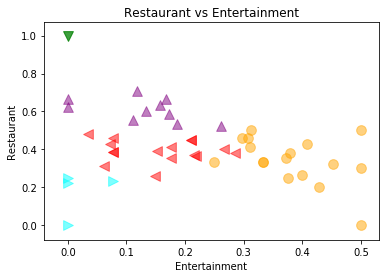

In [46]:
plt.figure(figsize=(6,4))

cluster0=properties_with_listings_merged.loc[properties_with_listings_merged['Cluster Labels'] == 0, properties_with_listings_merged.columns[[0,1,2,3] + list(range(4, properties_with_listings_merged.shape[1]))]]
cluster1=properties_with_listings_merged.loc[properties_with_listings_merged['Cluster Labels'] == 1, properties_with_listings_merged.columns[[0,1,2,3] + list(range(4, properties_with_listings_merged.shape[1]))]]
cluster2=properties_with_listings_merged.loc[properties_with_listings_merged['Cluster Labels'] == 2, properties_with_listings_merged.columns[[0,1,2,3] + list(range(4, properties_with_listings_merged.shape[1]))]]
cluster3=properties_with_listings_merged.loc[properties_with_listings_merged['Cluster Labels'] == 3, properties_with_listings_merged.columns[[0,1,2,3] + list(range(4, properties_with_listings_merged.shape[1]))]]
cluster4=properties_with_listings_merged.loc[properties_with_listings_merged['Cluster Labels'] == 4, properties_with_listings_merged.columns[[0,1,2,3] + list(range(4, properties_with_listings_merged.shape[1]))]]

area = 10*np.pi*3

x_column='Entertainment'
y_column='Restaurant'

plt.scatter(cluster0[x_column], cluster0[y_column], s=area, c='purple', alpha=0.5, marker="^")
plt.scatter(cluster1[x_column], cluster1[y_column], s=area, c='cyan', alpha=0.5, marker=">")
plt.scatter(cluster2[x_column], cluster2[y_column], s=area, c='green', alpha=0.5, marker="v")
plt.scatter(cluster3[x_column], cluster3[y_column], s=area, c='orange', alpha=0.5, marker="o")
plt.scatter(cluster4[x_column], cluster4[y_column], s=area, c='red', alpha=0.5, marker="<")

plt.title(y_column + ' vs ' + x_column)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.show()

**Restaurant vs Entertainment:** From this scatterplot, we can see that cluster 3 includes properties where the 'density' of Entertainment venues was above a threshold of ~0.25.   LloydMiller restaurant was in a desirable location, with lots to do in the area.  It is possible that having good entertainment options is a good thing to look for when selecting a new restaurant location.

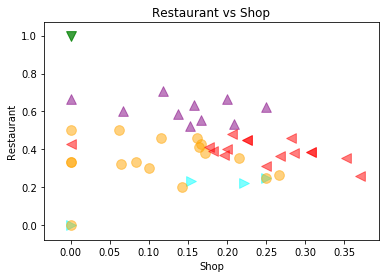

In [47]:
plt.figure(figsize=(6,4))

x_column='Shop'
y_column='Restaurant'

plt.scatter(cluster0[x_column], cluster0[y_column], s=area, c='purple', alpha=0.5, marker="^")
plt.scatter(cluster1[x_column], cluster1[y_column], s=area, c='cyan', alpha=0.5, marker=">")
plt.scatter(cluster2[x_column], cluster2[y_column], s=area, c='green', alpha=0.5, marker="v")
plt.scatter(cluster3[x_column], cluster3[y_column], s=area, c='orange', alpha=0.5, marker="o")
plt.scatter(cluster4[x_column], cluster4[y_column], s=area, c='red', alpha=0.5, marker="<")

plt.title(y_column + ' vs ' + x_column)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.show()

**Restaurant vs Shop:** From this scatterplot, we can see that cluster 3 includes properties where the 'density' of Restaurants and Shop venues were both below certain thresholds (imagine a rectangular region in the lower right quadrant of this scatter plot, with Restaurants < ~0.5 & Shop < ~0.25).  If Entertainment is important to have nearby for LloydMiller's new location, then it gathers that we would not have an excess of the other venue categories nearby.  For restaurants, this is intuitive, as we would not want too large of a density of nearby restaurants (as this also means competition).  For shops, this is less intuitive, but it could be that higher shop density may take away from Entertainment options.

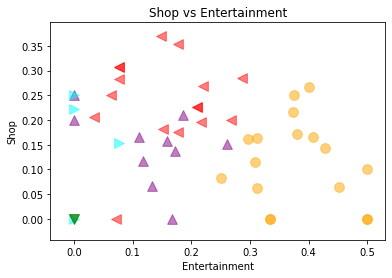

In [48]:
plt.figure(figsize=(6,4))

x_column='Entertainment'
y_column='Shop'

plt.scatter(cluster0[x_column], cluster0[y_column], s=area, c='purple', alpha=0.5, marker="^")
plt.scatter(cluster1[x_column], cluster1[y_column], s=area, c='cyan', alpha=0.5, marker=">")
plt.scatter(cluster2[x_column], cluster2[y_column], s=area, c='green', alpha=0.5, marker="v")
plt.scatter(cluster3[x_column], cluster3[y_column], s=area, c='orange', alpha=0.5, marker="o")
plt.scatter(cluster4[x_column], cluster4[y_column], s=area, c='red', alpha=0.5, marker="<")

plt.title(y_column + ' vs ' + x_column)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.show()

**Shop vs Entertainment:** From this scatterplot, we can see that Shop density does not really distinguish the cluster when compared to Entertainment.

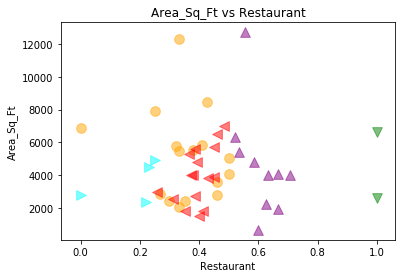

In [49]:
plt.figure(figsize=(6,4))

x_column='Restaurant'
y_column='Area_Sq_Ft'

plt.scatter(cluster0[x_column], cluster0[y_column], s=area, c='purple', alpha=0.5, marker="^")
plt.scatter(cluster1[x_column], cluster1[y_column], s=area, c='cyan', alpha=0.5, marker=">")
plt.scatter(cluster2[x_column], cluster2[y_column], s=area, c='green', alpha=0.5, marker="v")
plt.scatter(cluster3[x_column], cluster3[y_column], s=area, c='orange', alpha=0.5, marker="o")
plt.scatter(cluster4[x_column], cluster4[y_column], s=area, c='red', alpha=0.5, marker="<")

plt.title(y_column + ' vs ' + x_column)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.show()

**Area_Sq_Ft vs Restaurant:** I wanted to explore the variables that were not used in our clustering algorithm to see if there was any incidental correlation.  From this scatterplot, we can see that Area_Sq_Ft density does not really distinguish the cluster when compared to Restaurant density.

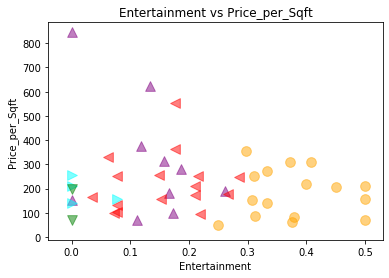

In [50]:
plt.figure(figsize=(6,4))

x_column='Entertainment'
y_column='Price_per_Sqft'

plt.scatter(cluster0[x_column], cluster0[y_column], s=area, c='purple', alpha=0.5, marker="^")
plt.scatter(cluster1[x_column], cluster1[y_column], s=area, c='cyan', alpha=0.5, marker=">")
plt.scatter(cluster2[x_column], cluster2[y_column], s=area, c='green', alpha=0.5, marker="v")
plt.scatter(cluster3[x_column], cluster3[y_column], s=area, c='orange', alpha=0.5, marker="o")
plt.scatter(cluster4[x_column], cluster4[y_column], s=area, c='red', alpha=0.5, marker="<")

plt.title(x_column + ' vs ' + y_column)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.show()


**Price_Sq_Ft vs Entertainment:** I wanted to explore the variables that were not used in our clustering algorithm to see if there was any incidental correlation.  From this scatterplot, we can see that Price_Sq_Ft density does not really distinguish the cluster when compared to Entertainment density.

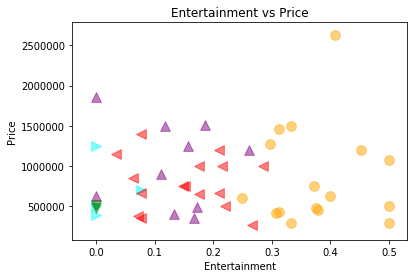

In [51]:
plt.figure(figsize=(6,4))

x_column='Entertainment'
y_column='Price'

plt.scatter(cluster0[x_column], cluster0[y_column], s=area, c='purple', alpha=0.5, marker="^")
plt.scatter(cluster1[x_column], cluster1[y_column], s=area, c='cyan', alpha=0.5, marker=">")
plt.scatter(cluster2[x_column], cluster2[y_column], s=area, c='green', alpha=0.5, marker="v")
plt.scatter(cluster3[x_column], cluster3[y_column], s=area, c='orange', alpha=0.5, marker="o")
plt.scatter(cluster4[x_column], cluster4[y_column], s=area, c='red', alpha=0.5, marker="<")

plt.title(x_column + ' vs ' + y_column)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.show()

**Price vs Entertainment:** I wanted to explore the variables that were not used in our clustering algorithm to see if there was any incidental correlation.  From this scatterplot, we can see that Price density does not really distinguish the cluster when compared to Entertainment density.

# Conclusion
The following list of properties is the reduced set of rental properties available near Naperville, IL that may be similar neighborhoods as the LloydMiller restaurant in the Queen Anne neighborhood in Seattle.

These properties are all characterized by having higher "Entertainment" venue density, moderate "Restaurant" density and lower "Shop" density as compared to the other property clusters.

In [52]:
cluster3[['Price','Price_per_Sqft']].head(16).sort_values(by=['Price_per_Sqft'])

,Price,Price_per_Sqft
Address,,
"211 N River St, Montgomery, IL",599000.0,48.699187
"75-77 S Lasalle St, Aurora, IL",475000.0,59.974747
"47 E Illinois Ave, Aurora, IL",289000.0,71.534653
"18027 Dixie Highway, Homewood, IL",449000.0,81.134803
"10036 S Western Ave, Chicago, IL",425000.0,84.830339
"155 E Veterans Parkway, Yorkville, IL",286000.0,141.865079
"227 W Wilson St, Batavia, IL",419000.0,150.882247
"720 E North Ave, Carol Stream, IL",1080000.0,157.022390
"460 S 1st St, Saint Charles, IL",1199000.0,208.449235


This is a much more manageable list of properties to review.  Additionally, we have learned that having nearby Entertainment options was an important variable in the k-means clustering, and it seems to make sense as well.

Subjectively, the properties nearby the Fox River may be desirable (Montgomery, Aurora, Batavia, Saint Charles & Yorkville) and are more reasonably priced (per square feet).